## Predict Suicidal Ideation Based on Tweets

<font>Suicidal ideation detection in online social networks is an emerging research area with major challenges. Recent research has shown that the publicly available information, spread across social media platforms, holds valuable indicators for effectively detecting individuals with suicidal intentions. The key challenge of suicide prevention is understanding and detecting the complex risk factors and warning signs that may precipitate the event. We present an approach that uses the social media platform <b>Twitter</b> to quantify suicide warning signs for individuals and to detect posts containing suicide-related content. The main originality of this approach is the automatic identification of sudden changes in a user's online behavior. To detect such changes, we combine natural language processing(NLP) techniques to aggregate behavioral and textual features and pass these features through a model framework, which is widely used for change detection in data.</font>

<div class="alert alert-block alert-info">
<font color='DodgerBlue'>This notebook, classifier the Tweets as 'Potentential-Suicidal'/'Non-Suicidal'. This is done by using the following techniques :
    <ul>
        <li>Import the data</li>
        <li>Data Cleaning - Removing Null, Missing Values, Renaming Columns</li>
        <li>Data Preprocessing - Lower-casing, NLTK, Removing Stop Words, Language Filtering, Lemmetization</li>
        <li>Count Vectorizer</li>
        <li>Modeling - Gaussian NB, Bernoulli NB, Random Forest, Ensemble, Decision Tree, Gradient Boosting, XGradient Boosting, AdaBoost. Deep Learning - 1-layer LSTM, 2-Layer LSTM, CNN + 2-LSTM</li>
        <li>K-Fold Cross Validation</li>
    </ul>
</font>
    </div>

### 1. Import Suicide train dataset

In [2]:
import re
import nltk
import pickle
import numpy as np
import collections
import pandas as pd
import tensorflow as tf
from sklearn import tree
from textblob import Word 
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.models import Sequential
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import KFold 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from keras.layers import Conv1D ,MaxPooling1D
from keras.preprocessing.text import Tokenizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.layers.core import Dropout, Activation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten
%matplotlib inline

Suicide = pd.read_csv("/Users/yeezhianliew/Desktop/Train_suicide1.csv",encoding ="ISO-8859-1") 
Suicide.head()

,Tweet,Suicide
0,i hate myself so much i want to KILL myself ho...,Potential Suicide post
1,RT @DrugForumsBest: I woke up with a bag over ...,Potential Suicide post
2,i wanna fucking kill myself,Potential Suicide post
3,why do i destroy all my opportunities? am i go...,Potential Suicide post
4,u - understand what the fuck im doing wrong wi...,Potential Suicide post


### 1.1 Dataset Shape 

In [3]:
Suicide.shape                                                 #shape of the dataset

(1599, 2)

### 2. Data Cleaning

<font color='DodgerBlue'>Data Cleaning - Removing Null, Missing Values, Renaming Columns.</font>

In [4]:
Suicide['Tweet']=Suicide['Tweet'].fillna("")                  #remove all the null value

### 3. Data Preprocessing

<font color='DodgerBlue'>
    <ul><li>Lower-casing</li>
    <li>NLTK</li> 
    <li>Removing Stop Words</li>
    <li>Language Filtering</li>
        <li>Lemmetization</li></ul>
</font>

In [5]:
Suicide['lower_case']= Suicide['Tweet'].apply(lambda x: x.lower())      
#Dataset['RT'] = Dataset['lower_case'].replace({"rt": ''}, regex=True)
tokenizer = RegexpTokenizer(r'\w+')
Suicide['Special_word'] = Suicide.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)    

freq = pd.Series(' '.join(Suicide['Tweet']).split()).value_counts()[-10:]                       
freq = list(freq.index)
Suicide['Contents'] = Suicide['Tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq)) 

stop = stopwords.words('english')
Suicide['stop_words'] = Suicide['Special_word'].apply(lambda x: [item for item in x if item not in stop])  

Suicide['stop_words'] = Suicide['stop_words'].astype('str')
Suicide['short_word'] = Suicide['stop_words'].str.findall('\w{3,}')         
Suicide['string'] =Suicide['stop_words'].replace({"'": '', ',': ''}, regex=True)
Suicide['string'] = Suicide['string'].str.findall('\w{3,}').str.join(' ') 

nltk.download('words')
words = set(nltk.corpus.words.words())
Suicide['NonEnglish'] = Suicide['string'].apply(lambda x: " ".join(x for x in x.split() if x in words))  

Suicide['tweet'] = Suicide['NonEnglish'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
Suicide.head()

[nltk_data] Downloading package words to
[nltk_data]     /Users/yeezhianliew/nltk_data...
[nltk_data]   Package words is already up-to-date!


,Tweet,Suicide,lower_case,Special_word,Contents,stop_words,short_word,string,NonEnglish,tweet
0,i hate myself so much i want to KILL myself ho...,Potential Suicide post,i hate myself so much i want to kill myself ho...,"[i, hate, myself, so, much, i, want, to, kill,...",i hate myself so much i want to KILL myself ho...,"['hate', 'much', 'want', 'kill', 'yâ', 'ð', 'ð']","[hate, much, want, kill]",hate much want kill,hate much want kill,hate much want kill
1,RT @DrugForumsBest: I woke up with a bag over ...,Potential Suicide post,rt @drugforumsbest: i woke up with a bag over ...,"[rt, drugforumsbest, i, woke, up, with, a, bag...",RT @DrugForumsBest: I woke up with a bag over ...,"['rt', 'drugforumsbest', 'woke', 'bag', 'head'...","[drugforumsbest, woke, bag, head, intentionall...",drugforumsbest woke bag head intentionally ove...,woke bag head intentionally half handle,woke bag head intentionally half handle
2,i wanna fucking kill myself,Potential Suicide post,i wanna fucking kill myself,"[i, wanna, fucking, kill, myself]",i wanna fucking kill myself,"['wanna', 'fucking', 'kill']","[wanna, fucking, kill]",wanna fucking kill,kill,kill
3,why do i destroy all my opportunities? am i go...,Potential Suicide post,why do i destroy all my opportunities? am i go...,"[why, do, i, destroy, all, my, opportunities, ...",why do i destroy all my opportunities? am i go...,"['destroy', 'opportunities', 'going', 'kill', ...","[destroy, opportunities, going, kill, accident...",destroy opportunities going kill accident get ...,destroy going kill accident get worse mean,destroy going kill accident get worse mean
4,u - understand what the fuck im doing wrong wi...,Potential Suicide post,u - understand what the fuck im doing wrong wi...,"[u, understand, what, the, fuck, im, doing, wr...",u - understand what the fuck im doing wrong wi...,"['u', 'understand', 'fuck', 'im', 'wrong', 'li...","[understand, fuck, wrong, life]",understand fuck wrong life,understand wrong life,understand wrong life


### 4. Applying n-gram (1,3)

<font color='DodgerBlue'>Splitting the data into Train-Test ratio of 67-33. Applying n-gram to Count Vectorizer and Fit-Transsform using Tf-IDF. </font>

In [6]:
x_train, x_test, y_train, y_test = train_test_split(Suicide["tweet"],Suicide["Suicide"], test_size = 0.33, random_state = 42)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer    
count_vect = CountVectorizer(ngram_range=(1, 3))               #set it to ngram (1,3)
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [7]:
print (x_train_tfidf.shape,x_test_tfidf.shape, y_train.shape, x_train.shape)

(1071, 9839) (528, 9839) (1071,) (1071,)


### 5. Machine Learning Model

<font color='DodgerBlue'> Using various Machine learning classifiers to Train, Test and Predict and Validate them.
</font>

### 5.1 Decision Tree

<font color='DodgerBlue'>Using Decision Tree Classifier for Classification and generating the Classification Report.</font>

In [8]:
model_1 = tree.DecisionTreeClassifier()  
model_1.fit(x_train_tfidf,y_train)
y_pred1 = model_1.predict(x_test_tfidf)
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test, y_pred1))

0.8295454545454546
                         precision    recall  f1-score   support

       Not Suicide post       0.87      0.87      0.87       345
Potential Suicide post        0.75      0.75      0.75       183

              micro avg       0.83      0.83      0.83       528
              macro avg       0.81      0.81      0.81       528
           weighted avg       0.83      0.83      0.83       528



#### K-Fold Cross Validation

In [9]:
scores_1 = cross_val_score(model_1, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred1))
print ("Cross-validated scores:", scores_1)

0.8295454545454546
Cross-validated scores: [0.85195531 0.86834734 0.86516854]


### 5.2 Random Forest

<font color='DodgerBlue'>Running the Random Forest with the following parameters and capturing the performance metrics
    <ul><li>n-estimators = 100</li>
        <li>max-depth = 9</li></ul></font>

In [12]:
from sklearn.ensemble import RandomForestClassifier                                
model_3 = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=0)
model_3.fit(x_train_tfidf,y_train)
y_pred3 = model_3.predict(x_test_tfidf)
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test, y_pred3))

0.6856060606060606
                         precision    recall  f1-score   support

       Not Suicide post       0.68      1.00      0.81       345
Potential Suicide post        1.00      0.09      0.17       183

              micro avg       0.69      0.69      0.69       528
              macro avg       0.84      0.55      0.49       528
           weighted avg       0.79      0.69      0.59       528



#### Cross Validation for Random Forest

In [13]:
scores_3 = cross_val_score(model_3, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred3))
print ("Cross-validated scores:", scores_3)

0.6856060606060606
Cross-validated scores: [0.68156425 0.66666667 0.66292135]


### 5.3 BernoulliNB 

<font color='DodgerBlue'>Running the BernoulliNB with the following parameters and capturing the performance metrics
    </font>

In [14]:
from sklearn.naive_bayes import BernoulliNB                                  
model_4= BernoulliNB(fit_prior=True)
model_4.fit(x_train_tfidf,y_train)
y_pred4 = model_4.predict(x_test_tfidf)
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test, y_pred4))

0.6912878787878788
                         precision    recall  f1-score   support

       Not Suicide post       0.68      1.00      0.81       345
Potential Suicide post        1.00      0.11      0.20       183

              micro avg       0.69      0.69      0.69       528
              macro avg       0.84      0.55      0.50       528
           weighted avg       0.79      0.69      0.60       528



#### Cross Validation 

In [15]:
scores_4 = cross_val_score(model_4, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred4))
print ("Cross-validated scores:", scores_4)

0.6912878787878788
Cross-validated scores: [0.71787709 0.70308123 0.6994382 ]


### 5.4 GradientBoostingClassifier 

<font color='DodgerBlue'>Running the GradientBoostingClassifier with the following parameters and capturing the performance metrics.
    </font>

In [16]:
from sklearn.ensemble import GradientBoostingClassifier                       
model_7 = GradientBoostingClassifier(n_estimators=1000,
                                        max_features='auto', max_depth=4,
                                        random_state=1, verbose=1)

model_7.fit(x_train_tfidf, y_train)
y_pred7 = model_7.predict(x_test_tfidf)
from sklearn.metrics import accuracy_score,classification_report
print(accuracy_score(y_test, y_pred7))
print(classification_report(y_test, y_pred7))

      Iter       Train Loss   Remaining Time 
         1           1.2161           20.32s
         2           1.1526           20.54s
         3           1.1008           22.03s
         4           1.0568           21.65s
         5           1.0214           21.69s
         6           0.9913           26.62s
         7           0.9616           29.81s
         8           0.9359           29.11s
         9           0.9110           31.36s
        10           0.8895           32.35s
        20           0.7485           39.30s
        30           0.6641           46.13s
        40           0.6044           45.73s
        50           0.5591           47.04s
        60           0.5182           43.54s
        70           0.4806           39.76s
        80           0.4533           39.59s
        90           0.4272           37.25s
       100           0.4068           35.50s
       200           0.2663           29.95s
       300           0.1911           25.75s
       40

#### Cross Validation

In [17]:
scores_7 = cross_val_score(model_7, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred7))
print ("Cross-validated scores:", scores_7)

      Iter       Train Loss   Remaining Time 
         1           1.2195           29.99s
         2           1.1580           30.95s
         3           1.1074           33.56s
         4           1.0655           32.43s
         5           1.0304           31.95s
         6           0.9995           33.48s
         7           0.9689           39.82s
         8           0.9426           41.07s
         9           0.9207           45.36s
        10           0.8976           45.83s
        20           0.7595           55.14s
        30           0.6756            1.21m
        40           0.6089            1.28m
        50           0.5540            1.26m
        60           0.5099            1.17m
        70           0.4758            1.13m
        80           0.4461            1.08m
        90           0.4180            1.02m
       100           0.3921           58.70s
       200           0.2416           44.85s
       300           0.1628           36.16s
       40

### 5.5 Ensemble

<font color='DodgerBlue'>Combining  DecisionTreeClassifier and RandomForestClassifier and capturing the performance metrics.
    </font>

In [18]:
from sklearn.ensemble import VotingClassifier                                   
DT = tree.DecisionTreeClassifier()
forest= RandomForestClassifier(n_estimators=500, max_depth=5, random_state=0)
model_6=VotingClassifier(estimators=[('Decision Tree', DT), ('Random Forest', forest)], 
                       voting='soft', weights=[1,2])                           #weight focus on better model
model_6.fit(x_train_tfidf,y_train)                                                   #vote predicts the class label based on the argmax 
y_pred6 = model_6.predict(x_test_tfidf)
print(accuracy_score(y_test, y_pred6))
print(classification_report(y_test, y_pred6))

0.8352272727272727
                         precision    recall  f1-score   support

       Not Suicide post       0.86      0.89      0.88       345
Potential Suicide post        0.78      0.73      0.75       183

              micro avg       0.84      0.84      0.84       528
              macro avg       0.82      0.81      0.81       528
           weighted avg       0.83      0.84      0.83       528



#### Cross Validation

In [19]:
scores_6 = cross_val_score(model_6, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred6))
print ("Cross-validated scores:", scores_6)

0.8352272727272727
Cross-validated scores: [0.84078212 0.85994398 0.85955056]


### 5.6 Random Forest 

<font color='DodgerBlue'>RandomForestClassifier with following parameters and capturing the performance metrics.
    <ul><li>n-estimators = 1000</li>
        <li>max-depth = 15</li></ul></font>

In [20]:
from sklearn.ensemble import RandomForestClassifier                                          
model_8 = RandomForestClassifier(n_estimators=1000, max_depth=15, random_state=0)
model_8.fit(x_train_tfidf, y_train)
y_pred8 = model_8.predict(x_test_tfidf)
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_pred8))
print(classification_report(y_test, y_pred8))

0.7651515151515151
                         precision    recall  f1-score   support

       Not Suicide post       0.74      1.00      0.85       345
Potential Suicide post        1.00      0.32      0.49       183

              micro avg       0.77      0.77      0.77       528
              macro avg       0.87      0.66      0.67       528
           weighted avg       0.83      0.77      0.72       528



#### Cross Validation

In [21]:
scores_8 = cross_val_score(model_8, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred8))
print ("Cross-validated scores:", scores_8)

0.7651515151515151
Cross-validated scores: [0.76536313 0.7535014  0.74438202]


### 5.7 XGB

<font color='DodgerBlue'>XGBClassifier with following parameters and capturing the performance metrics.
    <ul><li>learning_rate =0.1</li>
        <li>n_estimators=200</li>
    <li>objective= 'binary:logistic'</li></ul></font>

In [ ]:
from xgboost import XGBClassifier                                                         
model_9 = XGBClassifier( learning_rate =0.1, n_estimators=200,   
                        gamma=0, subsample=0.8, colsample_bytree=0.8,      
                        objective= 'binary:logistic', scale_pos_weight=1,seed=27)           
model_9.fit(x_train_tfidf, y_train)
y_pred9 = model_9.predict(x_test_tfidf)
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_pred9))
print(classification_report(y_test, y_pred9))

#### Cross-Validation

In [597]:
scores_9 = cross_val_score(model_9, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred9))
print ("Cross-validated scores:", scores_9)

0.865530303030303
Cross-validated scores: [0.87150838 0.88826816 0.89385475 0.88268156 0.87640449 0.88135593]


### 5.8 AdaBoost with DT

<font color='DodgerBlue'>AdaBoost with DecisionTreeClassifier</font>

In [23]:
from sklearn.tree import DecisionTreeClassifier                                  
from sklearn.ensemble import AdaBoostClassifier
dt1 = tree.DecisionTreeClassifier()
model_13= AdaBoostClassifier(base_estimator=dt1, learning_rate=0.5, n_estimators=300)
model_13.fit(x_train_tfidf, y_train)                                                   
y_pred13 = model_13.predict(x_test_tfidf)
print(accuracy_score(y_test, y_pred13))
print(classification_report(y_test, y_pred13))

0.8409090909090909
                         precision    recall  f1-score   support

       Not Suicide post       0.87      0.89      0.88       345
Potential Suicide post        0.78      0.75      0.77       183

              micro avg       0.84      0.84      0.84       528
              macro avg       0.83      0.82      0.82       528
           weighted avg       0.84      0.84      0.84       528



#### Cross-Validation

In [24]:
scores_13 = cross_val_score(model_13, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred13))
print ("Cross-validated scores:", scores_13)

0.8409090909090909
Cross-validated scores: [0.86871508 0.87114846 0.88202247]


### 5.9 AdaBoost with RF

<font color='DodgerBlue'>AdaBoost with RandomForestClassifier</font>

In [31]:
from sklearn.ensemble import AdaBoostClassifier
dt = RandomForestClassifier(n_estimators=40, max_depth=9, random_state=0)
model_14= AdaBoostClassifier(base_estimator=dt, learning_rate=0.2, n_estimators=100)
model_14.fit(x_train_tfidf, y_train)                                                   
y_pred14 = model_14.predict(x_test_tfidf)
print(accuracy_score(y_test, y_pred14))
print(classification_report(y_test, y_pred14))

0.8674242424242424
                         precision    recall  f1-score   support

       Not Suicide post       0.85      0.97      0.91       345
Potential Suicide post        0.92      0.67      0.78       183

              micro avg       0.87      0.87      0.87       528
              macro avg       0.89      0.82      0.84       528
           weighted avg       0.87      0.87      0.86       528



#### Cross-Validation

In [32]:
scores_14 = cross_val_score(model_14, x_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_pred14))
print ("Cross-validated scores:", scores_14)

0.8674242424242424
Cross-validated scores: [0.86871508 0.88515406 0.88764045]


### 6. Comparison of various ML algorithm

#### Comparing the metrics of the different classifiers

In [33]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
Comparison = pd.DataFrame({'DT': [accuracy_score(y_test,y_pred1)*100,f1_score(y_test,y_pred1,average='macro')*100,recall_score(y_test, y_pred1,average='micro')*100,precision_score(y_test, y_pred1,average='micro')*100],
                            'RF(n=100)': [accuracy_score(y_test,y_pred3)*100,f1_score(y_test,y_pred3,average='macro')*100,recall_score(y_test, y_pred3,average='micro')*100,precision_score(y_test, y_pred3,average='micro')*100 ],
                            'RF(n:1000)':[accuracy_score(y_test,y_pred8)*100,f1_score(y_test,y_pred8,average='macro')*100,recall_score(y_test, y_pred8,average='micro')*100,precision_score(y_test, y_pred8,average='micro')*100],
                            'BNB':[accuracy_score(y_test,y_pred4)*100,f1_score(y_test,y_pred4,average='macro')*100,recall_score(y_test, y_pred4, average='micro')*100 ,precision_score(y_test, y_pred4,average='micro')*100],
                            'GB':[accuracy_score(y_test,y_pred7)*100,f1_score(y_test,y_pred7,average='macro')*100,recall_score(y_test, y_pred7,average='micro')*100,precision_score(y_test, y_pred7,average='micro')*100],
                            'Ensemble':[accuracy_score(y_test,y_pred6)*100,f1_score(y_test,y_pred6,average='macro')*100,recall_score(y_test, y_pred6,average='micro')*100,precision_score(y_test, y_pred6,average='micro')*100],
                            'AdaBoost/DT':[accuracy_score(y_test,y_pred13)*100,f1_score(y_test,y_pred13,average='macro')*100,recall_score(y_test, y_pred13,average='micro')*100,precision_score(y_test, y_pred13,average='micro')*100],
                            'XGB':[accuracy_score(y_test,y_pred9)*100,f1_score(y_test,y_pred9,average='macro')*100,recall_score(y_test, y_pred9,average='micro')*100,precision_score(y_test, y_pred9,average='micro')*100], 
                            'AdaBoost/RF':[accuracy_score(y_test,y_pred14)*100,f1_score(y_test,y_pred14,average='macro')*100,recall_score(y_test, y_pred14,average='micro')*100,precision_score(y_test, y_pred14,average='micro')*100]})
    
        
print ('Comparison using N-gram(1,3)') 
Comparison.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Comparison.head()

Comparison using N-gram(1,3)


,DT,RF(n=100),RF(n:1000),BNB,GB,Ensemble,AdaBoost/DT,XGB,AdaBoost/RF
Accuracy,82.954545,68.560606,76.515152,69.128788,86.174242,83.522727,84.090909,86.553030,86.742424
F1_score,81.183179,48.803738,66.763458,50.297703,84.511462,81.489287,82.250964,84.166177,84.194321
Recall,82.954545,68.560606,76.515152,69.128788,86.174242,83.522727,84.090909,86.553030,86.742424
Precision,82.954545,68.560606,76.515152,69.128788,86.174242,83.522727,84.090909,86.553030,86.742424


### 7. Applying n-gram (1,2)

<font color='DodgerBlue'>Splitting the data into Train-Test ratio of 67-33. Applying n-gram(1,2) to Count Vectorizer and Fit-Transsform using Tf-IDF. </font>

In [149]:
X_train, X_test, y_train, y_test = train_test_split(Suicide["tweet"],Suicide["Suicide"], test_size = 0.33, random_state = 42)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(ngram_range=(1, 2))
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tfidf = transformer.transform(X_test_counts)

In [35]:
print (X_train_tfidf.shape,X_test_tfidf.shape, y_train.shape, x_train.shape)

(1071, 6101) (528, 6101) (1071,) (1071,)


### 8. Machine Learning Algorithm

#### 8.1 Decision Tree

<font color='DodgerBlue'>Using Decision Tree Classifier for Classification and generating the Classification Report.</font>

In [36]:
model_a = tree.DecisionTreeClassifier()                                    
model_a.fit(X_train_tfidf,y_train)
y_preda = model_a.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_preda))
print(classification_report(y_test, y_preda))

0.8314393939393939
                         precision    recall  f1-score   support

       Not Suicide post       0.86      0.89      0.87       345
Potential Suicide post        0.78      0.72      0.75       183

              micro avg       0.83      0.83      0.83       528
              macro avg       0.82      0.80      0.81       528
           weighted avg       0.83      0.83      0.83       528



#### Cross-Validation

In [37]:
scores_a = cross_val_score(model_a, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_preda))
print ("Cross-validated scores:", scores_a)

0.8314393939393939
Cross-validated scores: [0.83519553 0.86554622 0.85393258]


### 8.2 Random Forest

<font color='DodgerBlue'>Running the Random Forest with the following parameters and capturing the performance metrics
    <ul><li>n-estimators = 100</li>
        <li>max-depth = 9</li></ul></font>

In [38]:
model_b = RandomForestClassifier(n_estimators=1000, max_depth=9, random_state=0) 
model_b.fit(X_train_tfidf,y_train)
y_predb = model_b.predict(X_test_tfidf)
print(accuracy_score(y_test,y_predb))
print(classification_report(y_test, y_predb))

0.7121212121212122
                         precision    recall  f1-score   support

       Not Suicide post       0.69      1.00      0.82       345
Potential Suicide post        1.00      0.17      0.29       183

              micro avg       0.71      0.71      0.71       528
              macro avg       0.85      0.58      0.55       528
           weighted avg       0.80      0.71      0.64       528



In [39]:
scores_b = cross_val_score(model_b, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_predb))
print ("Cross-validated scores:", scores_b)

0.7121212121212122
Cross-validated scores: [0.70949721 0.70308123 0.68820225]


## 8.4 BernoulliNB

<font color='DodgerBlue'>Running the BernoulliNB with the following parameters and capturing the performance metrics
    </font>

In [150]:
from sklearn.naive_bayes import BernoulliNB                                  
model_c= BernoulliNB(fit_prior=True)
model_c.fit(X_train_tfidf,y_train)
y_predc = model_c.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_predc))
print(classification_report(y_test, y_predc))

0.7367424242424242
                         precision    recall  f1-score   support

       Not Suicide post       0.71      1.00      0.83       345
Potential Suicide post        1.00      0.24      0.39       183

              micro avg       0.74      0.74      0.74       528
              macro avg       0.86      0.62      0.61       528
           weighted avg       0.81      0.74      0.68       528



In [41]:
scores_c = cross_val_score(model_c, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_predc))
print ("Cross-validated scores:", scores_c)

0.7367424242424242
Cross-validated scores: [0.74581006 0.74789916 0.75      ]


###  8.4 Gradient Boosting

<font color='DodgerBlue'>Running the GradientBoostingClassifier with the following parameters and capturing the performance metrics.
    </font>


In [44]:
from sklearn.ensemble import GradientBoostingClassifier                       
model_d = GradientBoostingClassifier(n_estimators=5000,
                                        max_features='auto', max_depth=5,
                                        random_state=1, verbose=1)

model_d.fit(X_train_tfidf, y_train)
y_predd = model_d.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score,classification_report
print(accuracy_score(y_test, y_predd))
print(classification_report(y_test, y_predd))

      Iter       Train Loss   Remaining Time 
         1           1.2058            1.48m
         2           1.1348            1.51m
         3           1.0753            1.55m
         4           1.0260            1.54m
         5           0.9824            1.68m
         6           0.9450            1.87m
         7           0.9148            2.11m
         8           0.8890            2.09m
         9           0.8629            2.44m
        10           0.8394            2.41m
        20           0.6898            2.95m
        30           0.6028            2.97m
        40           0.5400            3.32m
        50           0.4894            3.66m
        60           0.4469            3.73m
        70           0.4148            3.71m
        80           0.3869            3.65m
        90           0.3622            3.47m
       100           0.3407            3.58m
       200           0.2090            3.27m
       300           0.1415            2.80m
       40

In [45]:
scores_d = cross_val_score(model_d, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_predd))
print ("Cross-validated scores:", scores_d)

      Iter       Train Loss   Remaining Time 
         1           1.2100           13.04m
         2           1.1407            8.89m
         3           1.0849            7.40m
         4           1.0374            8.35m
         5           0.9957            8.98m
         6           0.9603            7.94m
         7           0.9297            8.18m
         8           0.9024            7.81m
         9           0.8758            7.60m
        10           0.8544            7.69m
        20           0.7021            6.58m
        30           0.6101            5.96m
        40           0.5410            6.05m
        50           0.4872            5.84m
        60           0.4452            5.28m
        70           0.4095            5.21m
        80           0.3774            5.03m
        90           0.3503            4.97m
       100           0.3260            4.76m
       200           0.1826            3.79m
       300           0.1151            3.63m
       40

### 8.4 Ensemble

<font color='DodgerBlue'>Combining  DecisionTreeClassifier and RandomForestClassifier and capturing the performance metrics.
    </font>

In [46]:
from sklearn.ensemble import VotingClassifier                                    
DT = tree.DecisionTreeClassifier()
forest= RandomForestClassifier(n_estimators=500, max_depth=5, random_state=0)
model_e=VotingClassifier(estimators=[('Decision Tree', DT), ('Random Forest', forest)], 
                       voting='soft', weights=[1,2])                           #weight focus on better model
model_e.fit(X_train_tfidf,y_train)                                                   #vote predicts the class label based on the argmax 
y_prede = model_e.predict(X_test_tfidf)
print(accuracy_score(y_test, y_prede))
print(classification_report(y_test, y_prede))

0.8390151515151515
                         precision    recall  f1-score   support

       Not Suicide post       0.88      0.87      0.88       345
Potential Suicide post        0.76      0.78      0.77       183

              micro avg       0.84      0.84      0.84       528
              macro avg       0.82      0.82      0.82       528
           weighted avg       0.84      0.84      0.84       528



In [47]:
scores_e = cross_val_score(model_e, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_prede))
print ("Cross-validated scores:", scores_e)

0.8390151515151515
Cross-validated scores: [0.85195531 0.87955182 0.86235955]


### 8.5 Random Forest

<font color='DodgerBlue'>RandomForestClassifier with following parameters and capturing the performance metrics.
    <ul><li>n-estimators = 2000</li>
        <li>max-depth = 15</li></ul></font>

In [48]:
from sklearn.ensemble import RandomForestClassifier                                        
model_f = RandomForestClassifier(n_estimators=1000, max_depth= 15, random_state=0)
model_f.fit(X_train_tfidf, y_train)
y_predf = model_f.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_predf))
print(classification_report(y_test, y_predf))

0.7840909090909091
                         precision    recall  f1-score   support

       Not Suicide post       0.75      1.00      0.86       345
Potential Suicide post        0.99      0.38      0.55       183

              micro avg       0.78      0.78      0.78       528
              macro avg       0.87      0.69      0.70       528
           weighted avg       0.83      0.78      0.75       528



In [49]:
scores_f = cross_val_score(model_f, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_predf))
print ("Cross-validated scores:", scores_f)

0.7840909090909091
Cross-validated scores: [0.80167598 0.78711485 0.78089888]


### 8.6 XGB

<font color='DodgerBlue'>XGBClassifier with following parameters and capturing the performance metrics.
    <ul><li>learning_rate =0.1</li>
        <li>n_estimators=200</li>
    <li>objective= 'binary:logistic'</li></ul></font>

In [50]:
from xgboost import XGBClassifier                                                          
model_g = XGBClassifier( learning_rate =0.1, n_estimators=200,   
                        gamma=0, subsample=0.8, colsample_bytree=0.8,      
                        objective= 'binary:logistic', scale_pos_weight=1,seed=27)           
model_g.fit(X_train_tfidf, y_train)
y_predg = model_g.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_predg))
print(classification_report(y_test, y_predg))

0.8579545454545454
                         precision    recall  f1-score   support

       Not Suicide post       0.85      0.95      0.90       345
Potential Suicide post        0.89      0.68      0.77       183

              micro avg       0.86      0.86      0.86       528
              macro avg       0.87      0.82      0.83       528
           weighted avg       0.86      0.86      0.85       528



In [51]:
scores_g = cross_val_score(model_g, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_predg))
print ("Cross-validated scores:", scores_g)

0.8579545454545454
Cross-validated scores: [0.89944134 0.89355742 0.88202247]


### 8.7 AdaBoost with RF

<font color='DodgerBlue'>AdaBoost with DecisionTreeClassifier</font>

In [52]:
from sklearn.ensemble import AdaBoostClassifier                                
dt_stump = RandomForestClassifier(n_estimators=40, max_depth=9, random_state=0)
model_h= AdaBoostClassifier(base_estimator=dt_stump, learning_rate=0.1, n_estimators=100)
model_h.fit(X_train_tfidf, y_train)                                                   
y_predh = model_h.predict(X_test_tfidf)
print(accuracy_score(y_test, y_predh))
print(classification_report(y_test, y_predh))

0.8674242424242424
                         precision    recall  f1-score   support

       Not Suicide post       0.84      0.98      0.91       345
Potential Suicide post        0.94      0.66      0.77       183

              micro avg       0.87      0.87      0.87       528
              macro avg       0.89      0.82      0.84       528
           weighted avg       0.88      0.87      0.86       528



In [53]:
scores_h = cross_val_score(model_h, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_predh))
print ("Cross-validated scores:", scores_h)

0.8674242424242424
Cross-validated scores: [0.86592179 0.87955182 0.87078652]


### 8.8 AdaBoost with DT

<font color='DodgerBlue'>AdaBoost with DecisionTreeClassifier</font>

In [54]:
from sklearn.tree import DecisionTreeClassifier                               
from sklearn.ensemble import AdaBoostClassifier
dt_stump = tree.DecisionTreeClassifier()
model_i= AdaBoostClassifier(base_estimator=dt_stump, learning_rate=0.1, n_estimators=300)
model_i.fit(X_train_tfidf, y_train)                                                   
y_predi = model_i.predict(X_test_tfidf)
print(accuracy_score(y_test, y_predi))
print(classification_report(y_test, y_predi))

0.8484848484848485
                         precision    recall  f1-score   support

       Not Suicide post       0.88      0.89      0.88       345
Potential Suicide post        0.79      0.77      0.78       183

              micro avg       0.85      0.85      0.85       528
              macro avg       0.83      0.83      0.83       528
           weighted avg       0.85      0.85      0.85       528



In [55]:
scores_i = cross_val_score(model_i, X_train_tfidf,y_train, cv=3)   #3 fold validation
print(accuracy_score(y_test,y_predi))
print ("Cross-validated scores:", scores_i)

0.8484848484848485
Cross-validated scores: [0.8575419  0.85434174 0.89325843]


### 9 Comparison of various Models

In [57]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
Comparison = pd.DataFrame({'RF(1000)': [accuracy_score(y_test,y_predb)*100,f1_score(y_test,y_predb,average='macro')*100,recall_score(y_test, y_predb,average='micro')*100,precision_score(y_test, y_predb,average='micro')*100 ],
                            'RF(2000)':[accuracy_score(y_test,y_predc)*100,f1_score(y_test,y_predc,average='macro')*100,recall_score(y_test, y_predc,average='micro')*100,precision_score(y_test, y_predc,average='micro')*100],
                            'BNB':[accuracy_score(y_test,y_predd)*100,f1_score(y_test,y_predd,average='macro')*100,recall_score(y_test, y_predd, average='micro')*100 ,precision_score(y_test, y_predd,average='micro')*100],
                            'GB':[accuracy_score(y_test,y_prede)*100,f1_score(y_test,y_prede,average='macro')*100,recall_score(y_test, y_prede,average='micro')*100,precision_score(y_test, y_prede,average='micro')*100],
                            'Ensemble':[accuracy_score(y_test,y_predf)*100,f1_score(y_test,y_predf,average='macro')*100,recall_score(y_test, y_predf,average='micro')*100,precision_score(y_test, y_predf,average='micro')*100],
                            'DT': [accuracy_score(y_test,y_preda)*100,f1_score(y_test,y_preda,average='macro')*100,recall_score(y_test, y_preda,average='micro')*100,precision_score(y_test, y_preda,average='micro')*100],
                            'AdaBoost/DT':[accuracy_score(y_test,y_predi)*100,f1_score(y_test,y_predi,average='macro')*100,recall_score(y_test, y_predi,average='micro')*100,precision_score(y_test, y_predi,average='micro')*100],
                            'XGB':[accuracy_score(y_test,y_predg)*100,f1_score(y_test,y_predg,average='macro')*100,recall_score(y_test, y_predg,average='micro')*100,precision_score(y_test, y_predg,average='micro')*100],
                            'AdaBoost/RF':[accuracy_score(y_test,y_predh)*100,f1_score(y_test,y_predh,average='macro')*100,recall_score(y_test, y_predh,average='micro')*100,precision_score(y_test, y_predh,average='micro')*100]})
    
print ('Comparison using N-gram(1,2)')    
Comparison.rename(index={0:'Accuracy',1:'F1_score', 2: 'Recall',3:'Precision'}, inplace=True)
Comparison.head(100)

Comparison using N-gram(1,2)


,RF(1000),RF(2000),BNB,GB,Ensemble,DT,AdaBoost/DT,XGB,AdaBoost/RF
Accuracy,71.212121,73.674242,85.227273,83.901515,78.409091,83.143939,84.848485,85.795455,86.742424
F1_score,55.459853,60.999665,82.921691,82.296068,70.451823,81.009881,83.186587,83.274131,84.017988
Recall,71.212121,73.674242,85.227273,83.901515,78.409091,83.143939,84.848485,85.795455,86.742424
Precision,71.212121,73.674242,85.227273,83.901515,78.409091,83.143939,84.848485,85.795455,86.742424


## 10. Deep Learning

<font color='DodgerBlue'>Creating a Deep Learning model using LSTM</font>

In [58]:
n_most_common_words =1000
max_len = 20
tokenizer = Tokenizer(num_words=n_most_common_words)
tokenizer.fit_on_texts(Suicide['Tweet'].values)
sequences = tokenizer.texts_to_sequences(Suicide['Tweet'].values)
X_DeepLearning = pad_sequences(sequences, maxlen=max_len)

In [59]:
from keras.utils.np_utils import to_categorical
Suicide.loc[Suicide['Suicide'] == 'Potential Suicide post ' , 'LABEL'] = 0      #set potential suicide post as 0
Suicide.loc[Suicide['Suicide'] == 'Not Suicide post', 'LABEL'] = 1              #set non potential suicide post as 1
     
print(Suicide['LABEL'][:10])
labels = to_categorical(Suicide['LABEL'], num_classes=2)
print(labels[:])
if 'Suicide' in Suicide.keys():
    Suicide.drop(['Suicide'], axis=1)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: LABEL, dtype: float64
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [60]:
XX_train, XX_test, y_train, y_test = train_test_split(X_DeepLearning , labels, test_size=0.33, random_state=42)
print((XX_train.shape, y_train.shape, XX_test.shape, y_test.shape))

((1071, 20), (1071, 2), (528, 20), (528, 2))


### 10.1   Deep Learning Models

### 10.1.1.  1-Layer LSTM - with 15 Epochs

<font color='DodgerBlue'>Running 1 layer LSTM with the following parameters and capturing the performance metrics
    <ul><li>LSTM = 200</li>
        <li>activation = softmax</li>
    <li>loss = binary</li></ul></font>

In [64]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dropout, Activation
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
                                                                            # batch 500 lstm 20  dim . sigmoid cate %
epochs = 15                                                                   #batch 500 lstm 400, dim 128 sigmoid cate   64%
emb_dim = 128
batch_size = 500         # higher, training will be faster
model_w = Sequential()
model_w.add(Embedding(n_most_common_words,emb_dim, input_length=X_DeepLearning.shape[1]))
model_w.add(SpatialDropout1D(0.7))                                             
model_w.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))                     #64 as hidden layer # close 70% for each neural layer  
model_w.add(Dense(2, activation='softmax'))
model_w.compile(optimizer=tf.train.AdamOptimizer(),loss='binary_crossentropy', metrics=['acc']) #reduce memory  loss = 'mean_squared_logarithmic_error'
print(model_w.summary())                                                                           #categorical_crossentropy
history_w = model_w.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 128)           128000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 391,602
Trainable params: 391,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 963 samples, validate on 108 samples
Epoch 1/15
963/963 [==============================] - 9s 10ms/step - loss: 0.6894 - acc: 0.5649 - val_loss: 0.6705 - val_acc: 0.6481
Epoch 2/15
963/963 [==============================] - 2s 2ms/step - loss: 0.6622 - a

<font color='DodgerBlue'>Plot to verify the Accuracy</font>

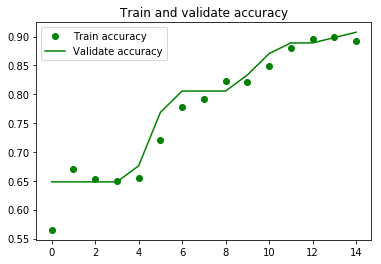

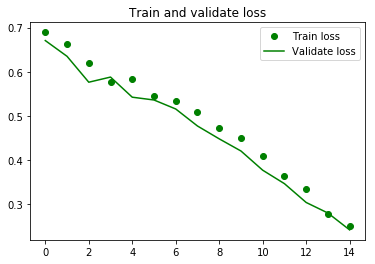

In [66]:
import matplotlib.pyplot as plt

acc = history_w.history['acc']                          #we can normalize input data in improve the model
val_acc = history_w.history['val_acc']
loss = history_w.history['loss']
val_loss = history_w.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            #pop up the list for train and validate acc box

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()                                             #show the graph

### 10.1.2.  2 LSTM

<font color='DodgerBlue'>Running 2 layers LSTM with the following parameters and capturing the performance metrics
    <ul><li>LSTM = 50</li>
         <li>LSTM = 200</li>
        <li>activation = softmax</li>
    <li>loss = binary</li></ul></font>

In [146]:
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Embedding, LSTM

epochs = 15
emb_dim = 32                       
batch_size = 200                  
model_y = Sequential()            
model_y.add(Embedding(n_most_common_words,emb_dim ,input_length=X_DeepLearning.shape[1]))
model_y.add(LSTM(50, dropout=0.3, recurrent_dropout=0.5, return_sequences=True))
model_y.add(LSTM(200, dropout=0.2, recurrent_dropout =0.5))
model_y.add(Dense(2, activation='softmax'))
model_y.compile(optimizer=tf.train.AdamOptimizer(),loss='binary_crossentropy', metrics=['acc']) 
print(model_y.summary())                                                                           #categorical_crossentropy
history_y = model_y.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 20, 32)            32000     
_________________________________________________________________
lstm_45 (LSTM)               (None, 20, 50)            16600     
_________________________________________________________________
lstm_46 (LSTM)               (None, 200)               200800    
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 402       
Total params: 249,802
Trainable params: 249,802
Non-trainable params: 0
_________________________________________________________________
None
Train on 856 samples, validate on 215 samples
Epoch 1/15
856/856 [==============================] - 29s 34ms/step - loss: 0.6825 - acc: 0.6005 - val_loss: 0.6242 - val_acc: 0.7070
Epoch 2/15
856/856 [==============================] - 2s 2ms/step - loss: 0.6284 - 

<font color='DodgerBlue'>Plot to verify the Accuracy</font>

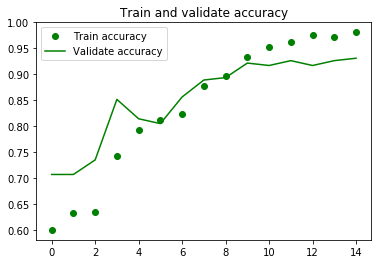

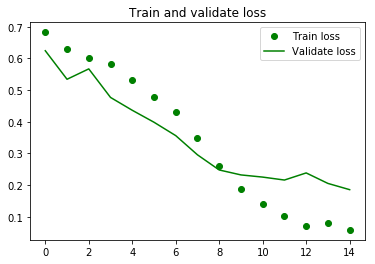

In [147]:
acc = history_y.history['acc']                          #we can normalize input data in improve the model
val_acc = history_y.history['val_acc']
loss = history_y.history['loss']
val_loss = history_y.history['val_loss']

plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            #pop up the list for train and validate acc box

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()                                             #show the graph

### 11.  CNN + LSTM

<font color='DodgerBlue'>Running CNN + 2 layers LSTM with the following parameters and capturing the performance metrics
    <ul><li>LSTM = 100</li>
         <li>LSTM = 50</li>
        <li>activation = softmax, relu</li>
        <li>pooling size = 2</li>
    <li>loss = binary</li></ul></font>

In [140]:
from keras.layers import Conv1D ,MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

epochs = 15
emb_dim = 15                                                                  
batch_size = 200
model_Z = Sequential()
model_Z.add(Embedding(n_most_common_words,emb_dim, input_length=X_DeepLearning.shape[1]))
model_Z.add(Conv1D(300, 6, padding='same'))
model_Z.add(Activation('relu'))
model_Z.add(MaxPooling1D(pool_size=2))
model_Z.add(Dropout(0.6))
model_Z.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model_Z.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model_Z.add(Dense(2, activation='softmax'))
model_Z.compile(optimizer=tf.train.AdamOptimizer(),loss='binary_crossentropy', metrics=['acc'])
print(model_Z.summary())                                                                           #categorical_crossentropy
historyZ = model_Z.fit(XX_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 20, 15)            15000     
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 20, 300)           27300     
_________________________________________________________________
activation_16 (Activation)   (None, 20, 300)           0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 10, 300)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 300)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 10, 100)           160400    
_________________________________________________________________
lstm_40 (LSTM)               (None, 50)                30200     
__________

<font color='DodgerBlue'>Plot to verify the Accuracy</font>

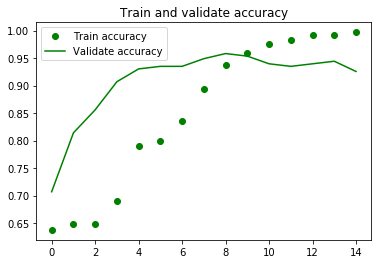

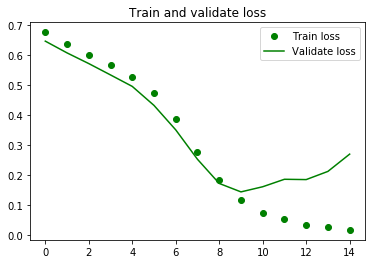

In [141]:
acc = historyZ.history['acc']                          #plot the graph that contains accuracy, loss and val_loss
loss = historyZ.history['loss']
val_loss = historyZ.history['val_loss']


plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                            #pop up the list for train and validate acc box

plt.figure()

plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()

plt.show()                                             #show the graph

## Save best model in hdf5 file

In [160]:
#!pip install h5py                                   # not recommend to save keras model in pickle , so we use hdf5 file
from keras.models import model_from_json
model_w_json = model_w.to_json()
with open("/Users/yeezhianliew/Desktop/model_w.json", "w") as json_file:
    json_file.write(model_w_json)
model_w.save_weights("/Users/yeezhianliew/Desktop/model_w.h5")
print("Saved model to disk")                        # save the model for testing later

Saved model to disk


## A little DEMO

In [107]:
all_word = []                              #set a dictionary for tweets and sentiment
for i in range(len(Suicide)):
    tweets = Suicide['tweet'][i]
    sentiment= Suicide['Suicide'][i]
    all_word.append((tweets,sentiment))

In [108]:
tweets = []                                 #set dictionary after filtering the word
for (words, sentiment) in all_word:
    words_filtered = [e.lower() for e in words.split() if len(e) >= 3] 
    tweets.append((words_filtered, sentiment))

In [109]:
def get_words_in_tweets(tweets):               #define get tweets' word
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words


def get_word_features(wordlist):              #define in a wordlist
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

word_features = get_word_features(get_words_in_tweets(tweets))

In [110]:
def extract_features(document):              # set features for each word
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [111]:
training_set = nltk.classify.apply_features(extract_features, tweets)     #apply the features

In [112]:
classifier = nltk.NaiveBayesClassifier.train(training_set)        #train data

In [113]:
print (classifier.show_most_informative_features(10))          #show the ratio 

Most Informative Features
           contains(die) = True           Potent : Not Su =     59.7 : 1.0
          contains(hate) = True           Potent : Not Su =     49.0 : 1.0
          contains(kill) = True           Potent : Not Su =     47.6 : 1.0
         contains(tired) = True           Potent : Not Su =     38.1 : 1.0
          contains(damn) = True           Potent : Not Su =     35.8 : 1.0
     contains(miserable) = True           Potent : Not Su =     27.8 : 1.0
        contains(living) = True           Potent : Not Su =     25.2 : 1.0
       contains(suicide) = True           Potent : Not Su =     24.1 : 1.0
    contains(everything) = True           Potent : Not Su =     18.3 : 1.0
     contains(literally) = True           Potent : Not Su =     17.9 : 1.0
None


In [166]:
#Example as below
#I am having a good thanksgiving and feeling bless                  
#I am thinking why the actor just kill himself, he sucks to the max!    
#today i almost kill myself because I almost hit by a car, thank lord  
#I want to hurt myself so badly, just want to die alone now             
#I dont know what to do anymore I lost my job, my wife left me. I am so fed up with my life 

tweet ='I dont know what to do anymore I lost my job, my wife left me. I am so fed up with my life '
print (classifier.classify(extract_features(tweet.split())))        #testing tweets

Potential Suicide post 
